In [1]:
import os
import scanpy as sc
import pandas as pd
import numpy as np
import scvelo as scv
import matplotlib.pyplot as plt

from twa.utils import ensure_dir
from twa.data import FlowSystemODE, topo_attr_spiral, topo_period_attr, topo_rep_spiral, interp_vectors
import random

random.seed(20)
load = False
save = False

fontsize=20
legend_fontsize=15

# Pancreas scVelo
Analysis following tutorial in:
https://scvelo.readthedocs.io/en/stable/vignettes/Fig3_pancreas/?highlight=pancreas

We generate vector fields depicting the differentiation process of pancreatic cells and their cell cycle label.

Filtered out 20801 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
Logarithmized X.
computing neighbors
    finished (0:00:37) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:02) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocities
    finished (0:00:04) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/32 cores)


  0%|          | 0/3696 [00:00<?, ?cells/s]

    finished (0:00:41) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:01) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


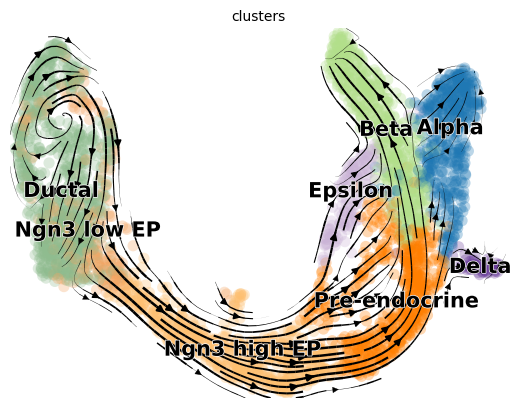

computing terminal states
    identified 2 regions of root cells and 1 region of end points .
    finished (0:00:01) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
calculating cell cycle phase
-->     'S_score' and 'G2M_score', scores of cell cycle phases (adata.obs)


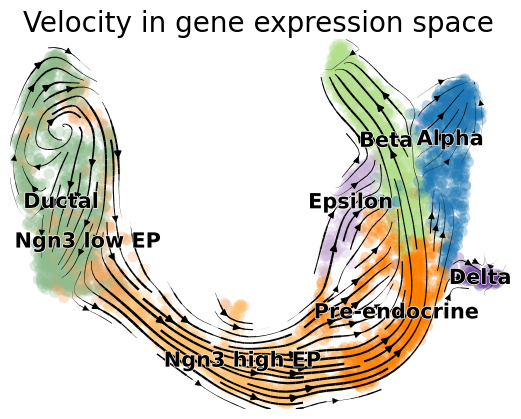

In [2]:
# add attributes to adata

outdir = '../output'
data_dir = os.path.join(outdir, 'datatrajs')

if load:
    adata = sc.read_h5ad(os.path.join(data_dir,'pancreas', 'adata.h5'))
else:
    adata = scv.datasets.pancreas()
    # preprocessing
    scv.pp.filter_and_normalize(adata, min_shared_counts=20, n_top_genes=2000)
    scv.pp.moments(adata, n_pcs=30, n_neighbors=30)
    # computing velocities
    scv.tl.velocity(adata)
    scv.tl.velocity_graph(adata)
    scv.pl.velocity_embedding_stream(adata, basis='umap', legend_fontsize=legend_fontsize)
    # compute velocity pseudotime
    scv.tl.velocity_pseudotime(adata)
    # angle
    vectors = adata.obsm['velocity_umap']
    angle = np.arctan2(vectors[...,1], vectors[...,0])
    adata.obs['angle'] = angle

    # cell cycle
    scv.tl.score_genes_cell_cycle(adata)
    
scv.pl.velocity_embedding_stream(adata, basis='umap', legend_fontsize=legend_fontsize, show=False)
plt.title('Velocity in gene expression space', fontsize=fontsize)
plt.show()

Text(0.5, 0, 'S-score')

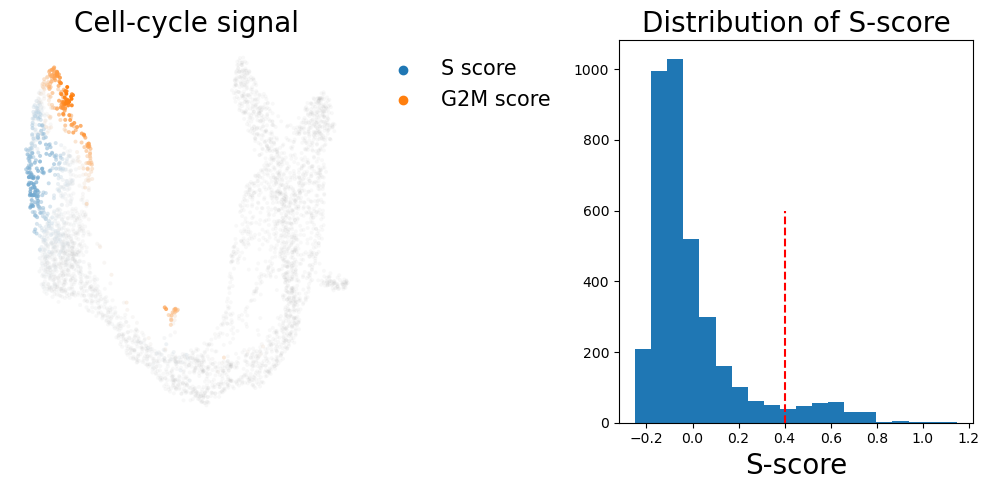

In [3]:
# cell cycle scores
fig, ax = plt.subplots(1,2, figsize=(10,5), constrained_layout=True, tight_layout=False)
scv.pl.scatter(adata, color_gradients=['S_score', 'G2M_score'], smooth=True, show=False, legend_fontsize=legend_fontsize, ax=ax[0])
ax[0].set_title('Cell-cycle signal', fontsize=fontsize)
    
ax[1].hist(adata.obs['S_score'], bins=20)
ax[1].plot([0.4, 0.4], [0, 600], 'r--')
ax[1].set_title('Distribution of S-score', fontsize=fontsize)
ax[1].set_xlabel('S-score', fontsize=20)

Ductal
Ngn3 low EP
Ngn3 high EP
Pre-endocrine
Beta
Alpha
Delta
Epsilon


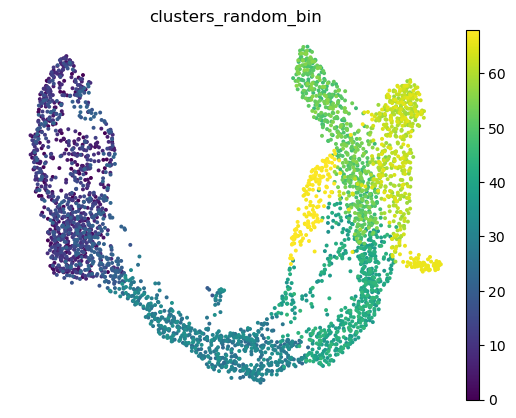

In [4]:
# split by both pseudotime and clusters such that each bin has > x cells

min_cells_per_bin = 50
df = pd.DataFrame(index=adata.obs.index)
df['clusters'] = adata.obs['clusters']
df['velocity_pseudotime'] = adata.obs['velocity_pseudotime']
samples = list(adata.obs['clusters'].cat.categories)
i = 0
for t in samples:
    print(t)
    sadata = adata[adata.obs['clusters'] == t]
    nbins = int(np.floor(sadata.shape[0] / min_cells_per_bin)) 
    if nbins > 1:
        intervals = pd.qcut(sadata.obs['velocity_pseudotime'], nbins)
        # enumerate intervals by their order
        intervals = intervals.cat.rename_categories(np.arange(i, i + nbins)).astype(int)
        random_intervals = np.random.permutation(intervals)
        # check for nan
        if np.any(np.isnan(intervals.astype(int).values)):
            break

    else:
        intervals = i
        random_intervals = i
        nbins = 1
    i += nbins
    df.loc[sadata.obs.index, 'clusters_pseudotime_bin'] = intervals
    df.loc[sadata.obs.index, 'clusters_random_bin'] = random_intervals
    
adata.obs['clusters_pseudotime_bin'] = df['clusters_pseudotime_bin'].astype(int)
adata.obs['clusters_random_bin'] = df['clusters_random_bin'].astype(int)

sc.pl.umap(adata, color='clusters_random_bin', frameon=False, wspace=.05)

In [5]:
# setting 
splitby = 'clusters_random_bin'

samples = list(adata.obs[splitby].cat.categories) if adata.obs[splitby].dtype == 'category' else list(adata.obs[splitby].unique())
adata.obs[splitby].unique()
n_samples = len(samples)

data_dir = os.path.join(data_dir, f'pancreas_{splitby}')

if save:
    ensure_dir(data_dir)


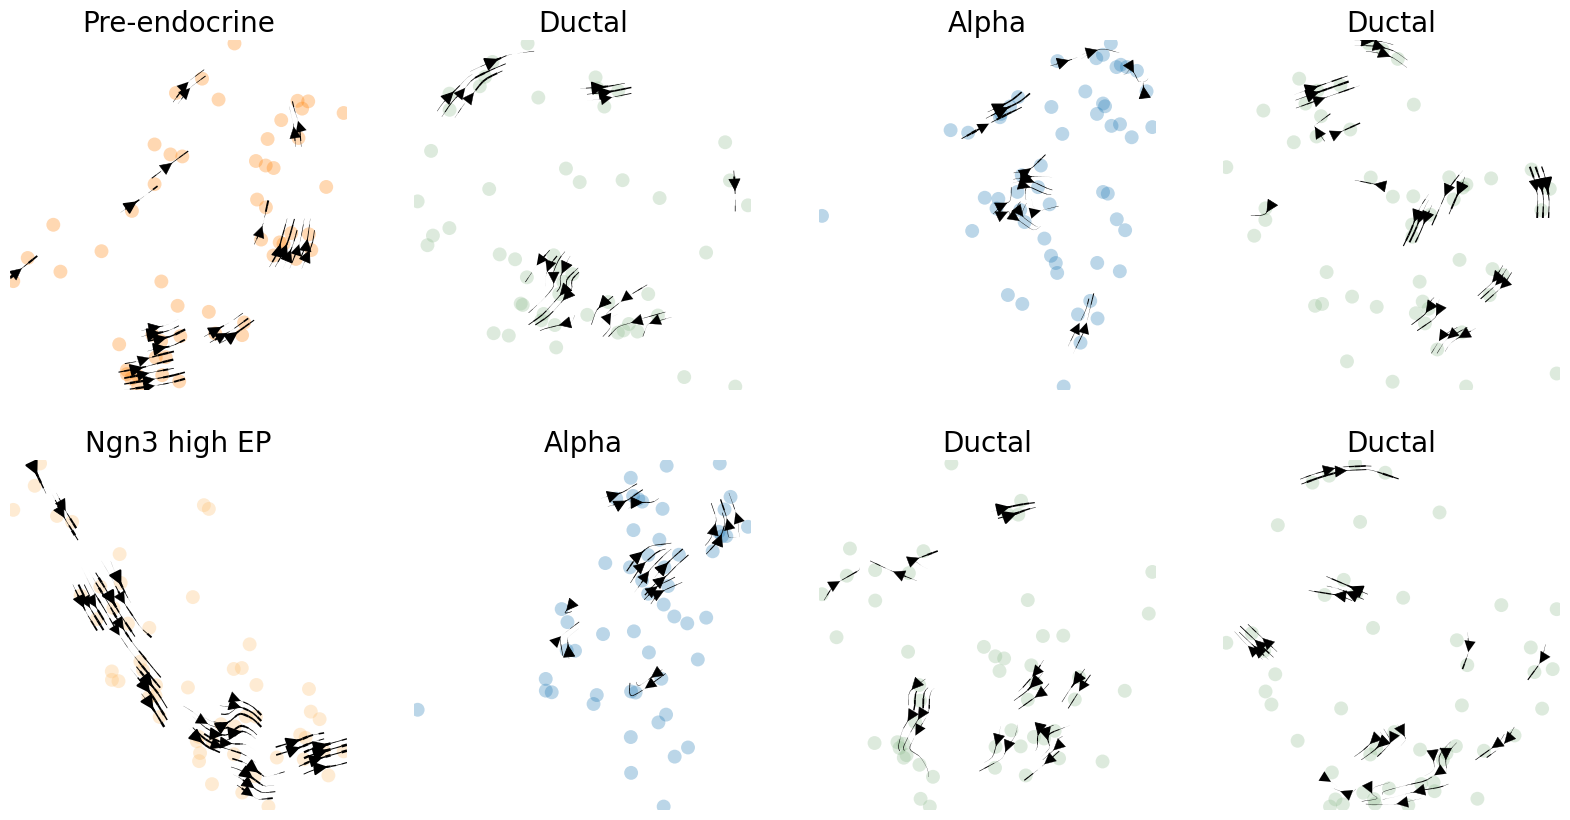

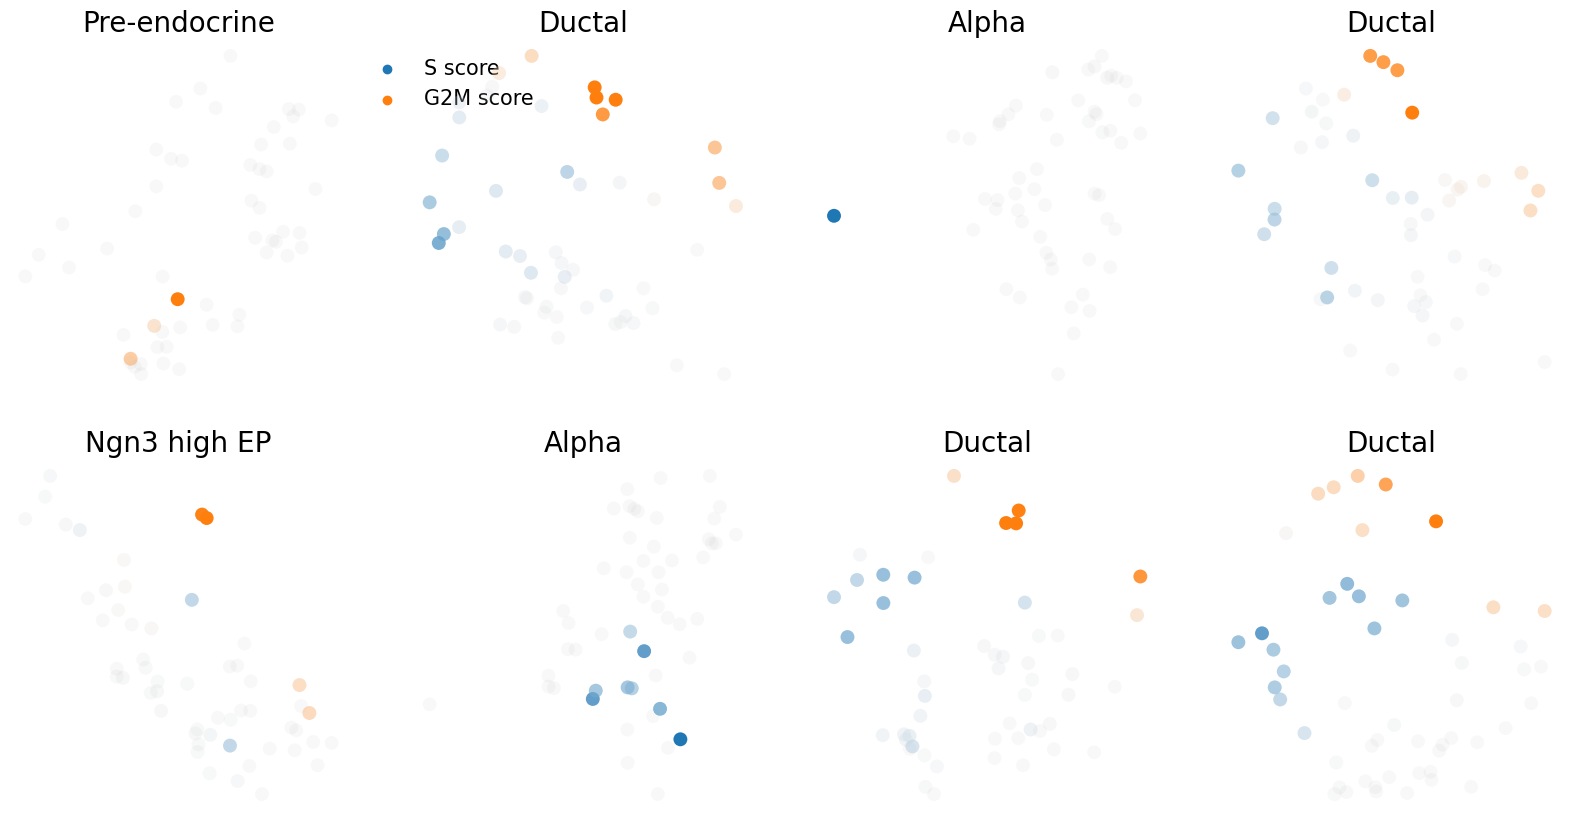

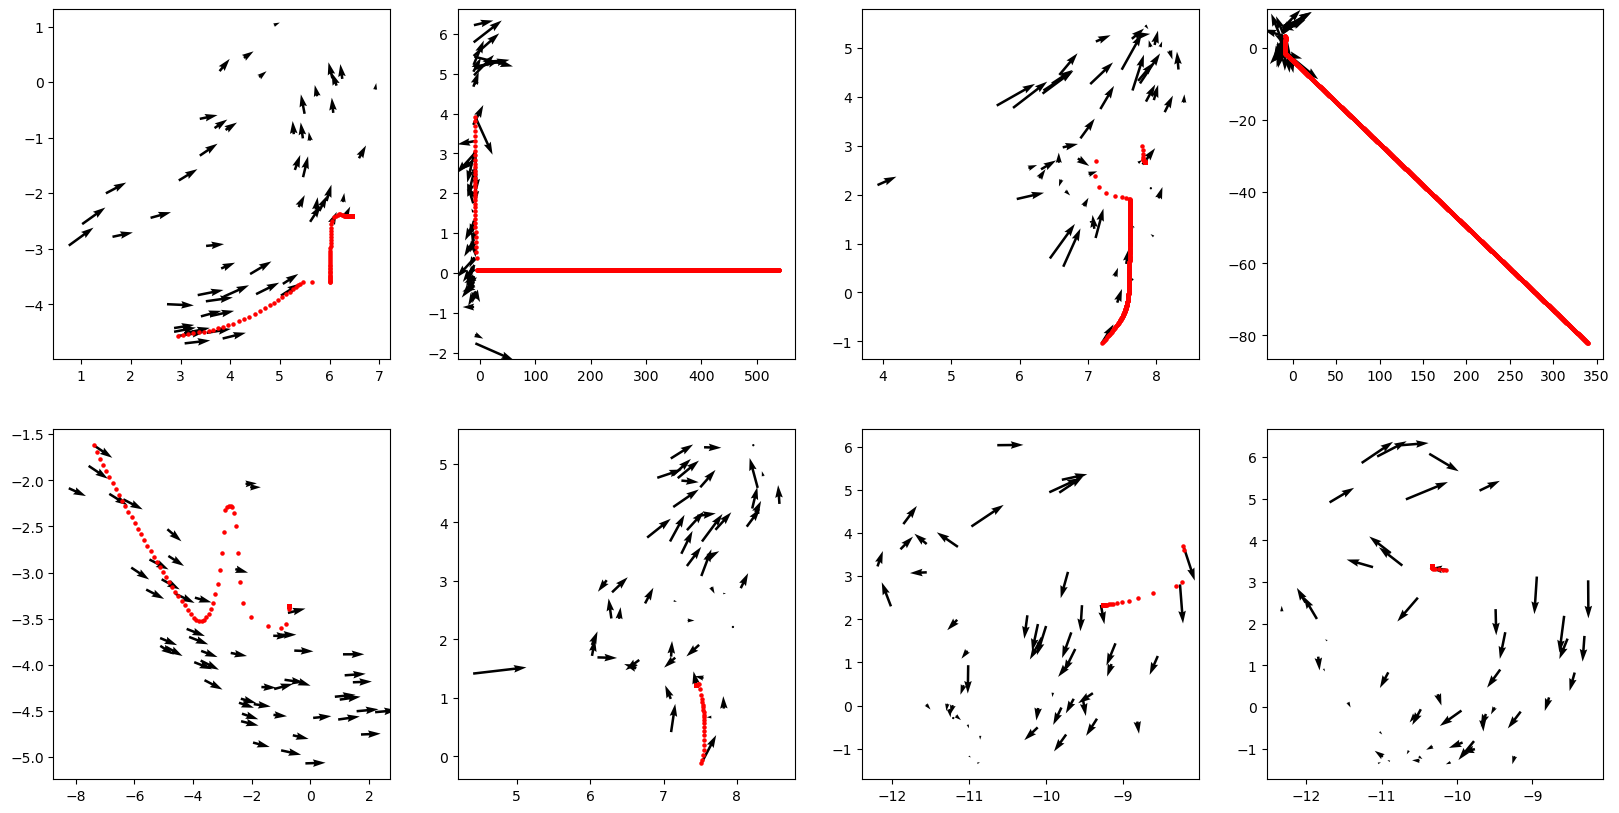

In [6]:
# plotting example vector fields and cell cycle score per cluster
import twa

T = 100
alpha = 0.1

T = 1000
alpha = 1

nrows = 2 
ncols = min(n_samples // nrows, 4)

fig, ax = plt.subplots(nrows, ncols, figsize=(ncols*5, nrows*5))
fig2, ax2 = plt.subplots(nrows, ncols, figsize=(ncols*5, nrows*5))
fig3, ax3 = plt.subplots(nrows, ncols, figsize=(ncols*5, nrows*5))
n_psamples = nrows * ncols

for i, t in enumerate(samples):
    sadata = adata[adata.obs[splitby] == t]
    
    if i >= n_psamples:
        break
    ty = sadata.obs['clusters'].iloc[0]
    scv.pl.velocity_embedding_stream(sadata, basis='umap', title=t, ax=ax[i//ncols, i%ncols], show=False, size=400, arrow_size=2, legend_loc='none')
    ax[i//ncols, i%ncols].set_title(ty, fontsize=fontsize)
    
    vectors = sadata.obsm['velocity_umap']
    coords = sadata.obsm['X_umap']
    
    legend_loc = None if i==0 else 'none'
    scv.pl.scatter(sadata, color_gradients=['S_score', 'G2M_score'], smooth=True, show=False, ax=ax2[i//ncols, i%ncols], size=400,legend_fontsize=legend_fontsize, legend_loc=legend_loc) #perc=[5, 95], 
    ax2[i//ncols, i%ncols].set_title(ty, fontsize=fontsize)

    init = coords[np.argmin(sadata.obs['velocity_pseudotime'])]
    traj = twa.dt.FlowSystemODE.integrate_vector_field(coords, vectors, T=T, alpha=alpha, init=init, plot=True, ax=ax3[i//ncols, i%ncols])
    
    
plt.show()

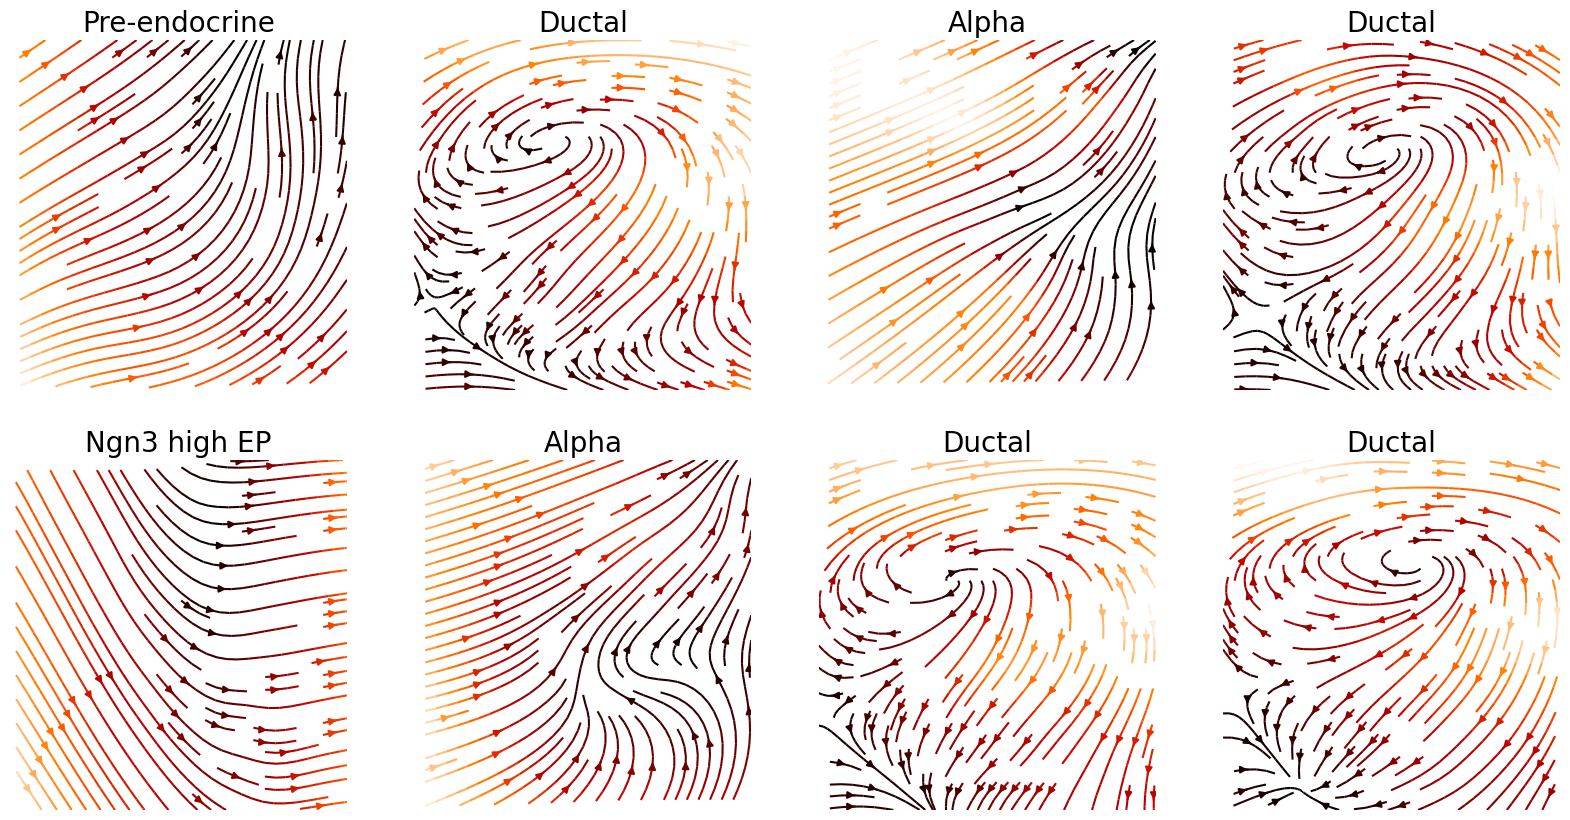

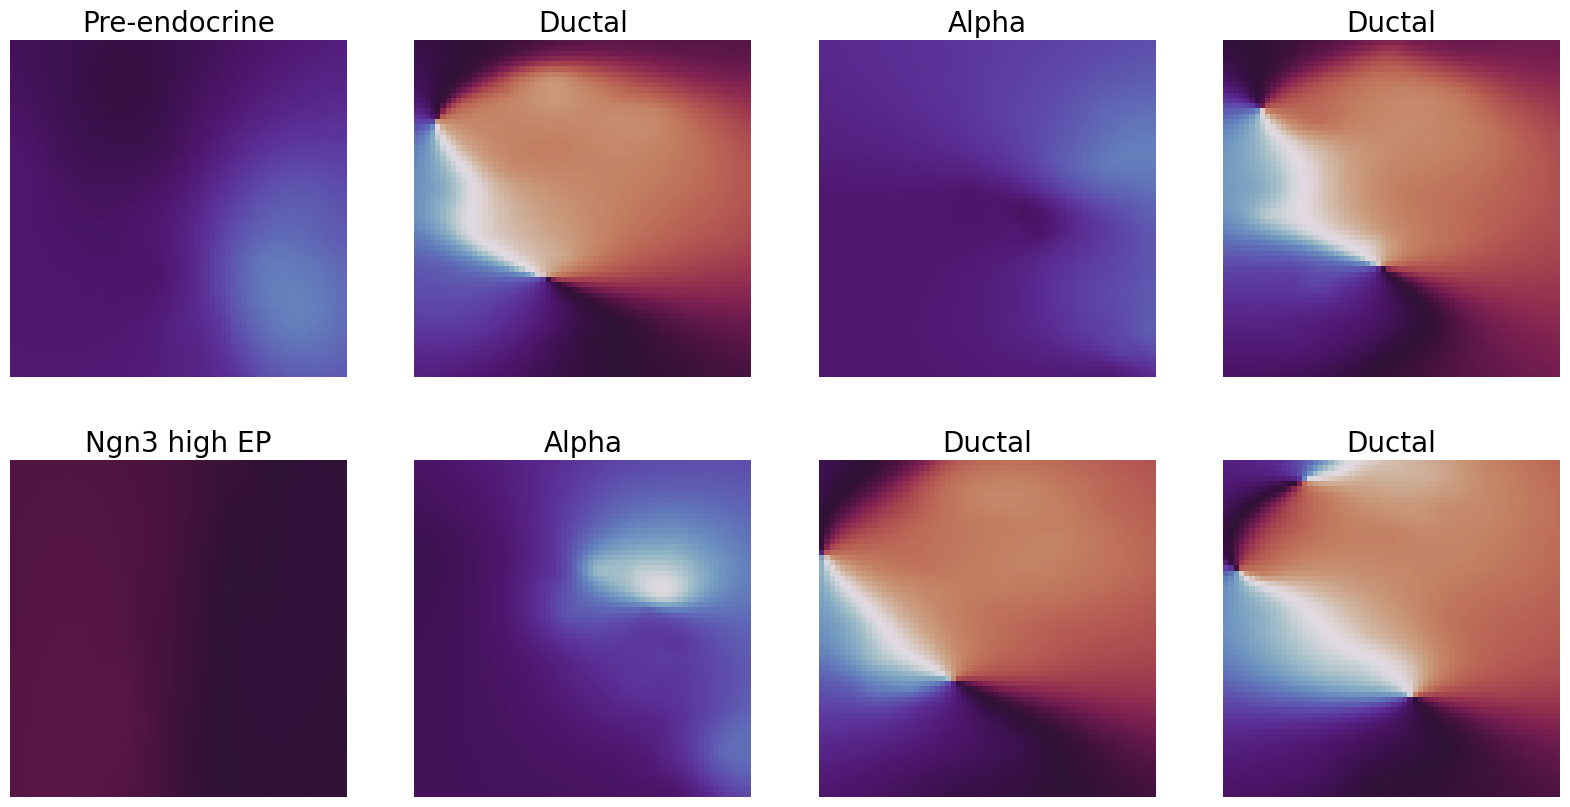

In [10]:
# saving by pseudotime
fig, ax = plt.subplots(nrows, ncols, figsize=(ncols*5, nrows*5))
fig2, ax2 = plt.subplots(nrows, ncols, figsize=(ncols*5, nrows*5))
# fig3, ax3 = plt.subplots(nrows, ncols, figsize=(ncols*5, nrows*5))

all_vectors = []
all_trajs = []
for i,t in enumerate(samples):
    sadata = adata[adata.obs[splitby] == t]

    cell_coords = sadata.obsm['X_umap']
    cell_vectors = sadata.obsm['velocity_umap']
    coords, vectors = interp_vectors(cell_coords, cell_vectors)

    init = cell_coords[np.argmin(sadata.obs['velocity_pseudotime'])]
    trajs = twa.dt.FlowSystemODE.integrate_vector_field(coords, vectors, T=T, alpha=alpha, init=init, plot=False, ax=None)

    if i < n_psamples:
        tit = sadata.obs['clusters'].iloc[0]
        FlowSystemODE.plot_trajectory_2d_(coords=coords, vectors=vectors, title=tit, ax=ax[i//ncols, i%ncols], fontsize=fontsize)
    
    if i < n_psamples:
        FlowSystemODE.plot_angle_image_(vectors, add_colorbar=False, ax=ax2[i//ncols, i%ncols])
        ax2[i//ncols, i%ncols].set_title(tit, fontsize=fontsize)
        ax2[i//ncols, i%ncols].invert_yaxis()

        ax[i//ncols, i%ncols].axis('off')
        ax2[i//ncols, i%ncols].axis('off')

    # if i < n_psamples:
    #     traj = twa.dt.FlowSystemODE.integrate_vector_field(coords, vectors, T=T, alpha=alpha, init=init, plot=True, ax=ax3[i//ncols, i%ncols])
    
    all_vectors.append(vectors)
    all_trajs.append(trajs)

all_vectors = np.stack(all_vectors)
all_trajs = np.stack(all_trajs)

if save:
    np.save(os.path.join(data_dir, 'X_test.npy'), all_vectors)
    np.save(os.path.join(data_dir, 'trajs_test.npy'), trajs)


In [8]:
# generate topology based on S_score
# score by fraction of cells past threshold?
thr_cell_in_s = 0.4
thr_pop_cyc = 0.1
topo = np.zeros((n_samples, 3), dtype=int)
sysp = np.zeros(n_samples)

label = f'frac_by_{splitby}'
adata.obs[label] = 0

for i,t in enumerate(samples):
    sadata = adata[adata.obs[splitby] == t]

    frac_in_s = np.sum(sadata.obs['S_score'] > thr_cell_in_s) / len(sadata.obs['S_score'])
    sysp[i] = np.round(frac_in_s, 3)
    topo[i] = [topo_rep_spiral, topo_period_attr, 0] if thr_pop_cyc < frac_in_s else [topo_attr_spiral, 0, 0]
    adata.obs.loc[sadata.obs.index, label] = frac_in_s
    
if save:
    np.save(os.path.join(data_dir, 'topo_test.npy'), topo)
    np.save(os.path.join(data_dir, 'sysp_test.npy'), sysp)
    np.save(os.path.join(data_dir, 'dists_test.npy'), np.abs(sysp - thr_pop_cyc))


In [9]:
if save:
    adata_dir = os.path.join(data_dir, 'pancreas')
    ensure_dir(adata_dir)
    fname = os.path.join(adata_dir, 'adata.h5')
    adata.write(fname)